# Clustering 3K PBMCs with Adversarial Autoencoders

<img src="adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results
from AAE2 import *

Using TensorFlow backend.


## Import dataset

In [2]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz


mkdir: cannot create directory ‘data’: File exists
--2019-06-07 09:22:39--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 143.204.247.100, 143.204.247.106, 143.204.247.13, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|143.204.247.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.04s   

2019-06-07 09:22:39 (193 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.15.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

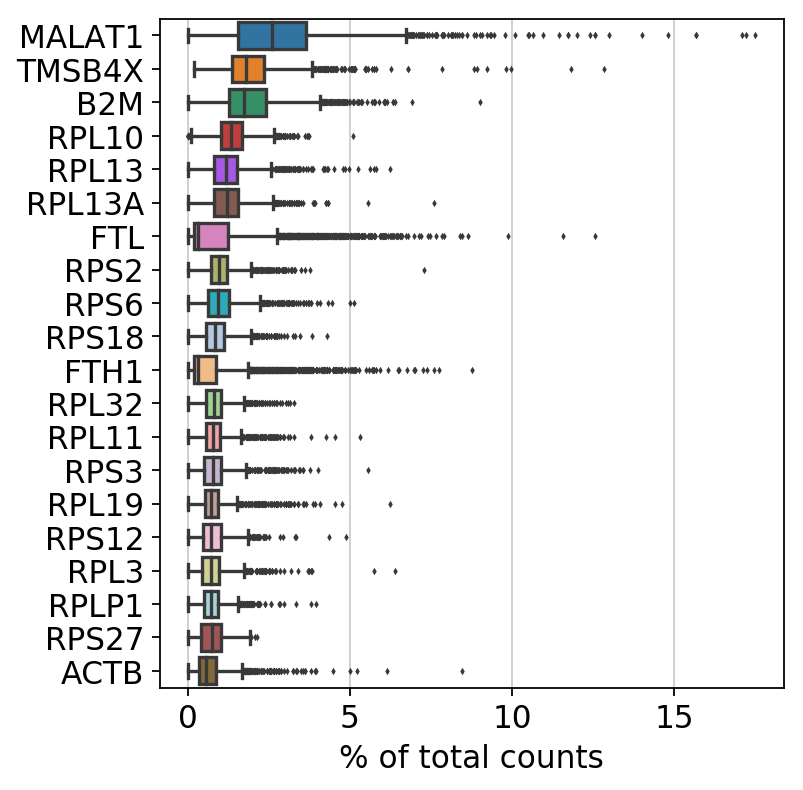

filtered out 19024 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['n_genes'] < 2500, :]

In [8]:
# Data in log scale
sc.pp.log1p(adata)

In [9]:
adata.obs.shape

(2695, 1)

In [10]:
adata.obs.head()

n_genes
0                        
AAACATACAACCAC-1      781
AAACATTGAGCTAC-1     1352
AAACATTGATCAGC-1     1131
AAACCGTGCTTCCG-1      960
AAACCGTGTATGCG-1      522

In [11]:
adata.var.shape

(13714, 2)

In [12]:
adata.var.head()

gene_ids  n_cells
AL627309.1     ENSG00000237683        9
AP006222.2     ENSG00000228463        3
RP11-206L10.2  ENSG00000228327        5
RP11-206L10.9  ENSG00000237491        3
LINC00115      ENSG00000225880       18

In [13]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [14]:
gene_names = adata.var_names.values

In [15]:
data = adata.X.toarray()
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


In [16]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

## Adversarial Autoencoder Model

### Network parameters

In [17]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 100
batch_size = 128
latent_dim = 50
epochs = 200

In [18]:
encoder, decoder, discriminator, generator, aae = build_AAE(original_dim, latent_dim, layer_1_dim, layer_2_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
print("\nEncoder Network")
print("===============")
encoder.summary()
os.makedirs('img', exist_ok=True)
plot_model(encoder, to_file='img/aae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 13714)        0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 13714)        0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          1371400     DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 100)               5000      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 100)               400       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 100)               0         
_________________________________________________________________
D1 (Dropout)                 (None, 100)               0         
_________________________________________________________________
H2 (Dense)                   (None, 100)               1000

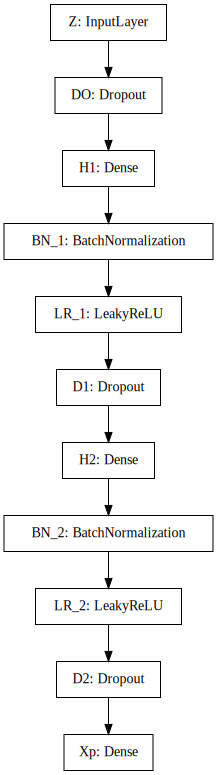

In [20]:
print("\nDecoder Network")
print("===============")
decoder.summary()
plot_model(decoder, to_file='img/aae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 13714)             0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1392300   
_________________________________________________________________
decoder (Model)              (None, 13714)             1400914   
Total params: 2,793,214
Trainable params: 2,792,414
Non-trainable params: 800
_________________________________________________________________


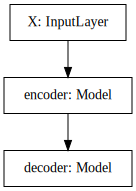

In [21]:
print("\nAutoencoder Network")
print("===================")
aae.summary()
plot_model(aae, to_file='img/aae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))

In [22]:
print("\nGenerator Network")
print("===================")
generator.summary()
plot_model(generator, to_file='img/aae_generator.png', show_shapes=True)
SVG(model_to_dot(generator).create(prog='dot', format='svg'))


Generator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 13714)             0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1392300   
_________________________________________________________________
discriminator (Model)        (None, 1)                 15901     
Total params: 1,408,201
Trainable params: 1,407,401
Non-trainable params: 800
_________________________________________________________________


In [23]:
print("\nDiscriminator Network")
print("=====================")
discriminator.summary()
plot_model(discriminator, to_file='img/aae_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))


Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 100)               5000      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 100)               400       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 100)               0         
_________________________________________________________________
D1 (Dropout)                 (None, 100)               0         
_________________________________________________________________
H2 (Dense)                   (None, 100)             

### Model training

In [24]:
# graph=True to show the data oints in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = train_AAE(aae, generator, discriminator, encoder, decoder,
                                          data, batch_size, latent_dim, epochs, 
                                          gene, gene_names, graph=True, 
                                          val_split=0.0)

# save models
os.makedirs('models', exist_ok=True)
aae.save('models/aae_autoencoder.h5')
generator.save('models/aae_generator.h5')
encoder.save('models/aae_encoder.h5')
decoder.save('models/aae_decoder.h5')
discriminator.save('models/aee_discriminator.h5') 

Epoch 200/200, reconstruction loss: 1.047253, generation loss: 0.301625, discriminator loss: 0.563422


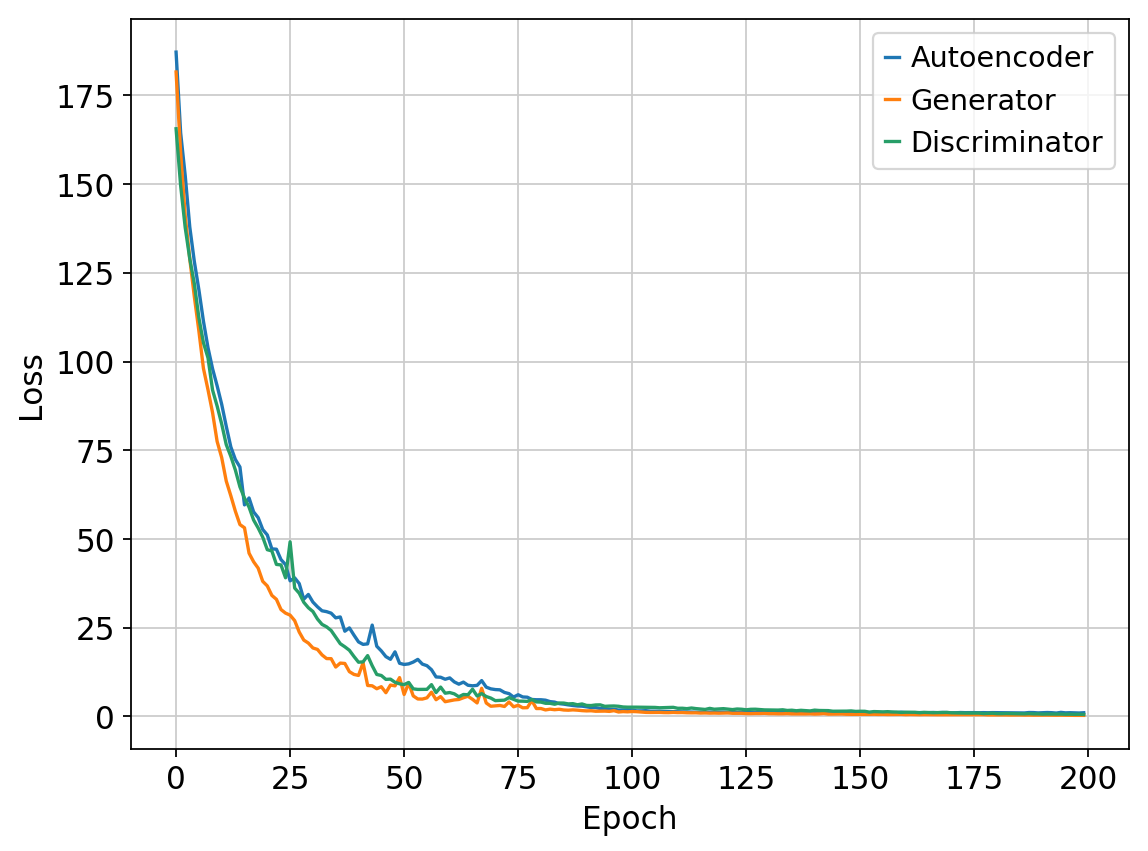

In [27]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

In [28]:
models = (encoder, decoder)
gene_list = ['CST3', 'MALAT1', 'NKG7']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

pca = PCA(n_components=2500)
pca.fit(data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')